# Hungarian Multi Rings

**Goal:** In the past notebooks
- `SA-mini`
- `SA-warm-up`

I've been focusing on a single ring to stay in a good range for the hyperparameters.

**Now:** Really understand what `scipy.optimize.linear_sum_assignment` function is doing.

I think the setup that I had from the earlier notebooks should be ok, but it's just a bit of syntax to follow-up on now :)

In [199]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import torch
import torch.nn.functional as F

from scipy.optimize import linear_sum_assignment


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Toy problem for debugging

OK, this is great, but I think I can make this even a little bit simpler for debugging!

<img src="attn-2-rings-graphic.png" style="height:250px" align="left" />

In [189]:
true = torch.FloatTensor([[[1,0,0],[0,1,0]],
                          [[0,0,1],[0,1,0]]
                         ])
true.shape

torch.Size([2, 2, 3])

In [190]:
pred = torch.FloatTensor([[[.9,.4,0.],[.1,.1,.1],[0,.6,.9]],
                          [[.9,.3,0.],[.1,.5,.1],[.9,.3,0.]]
                         ])

pred.shape

torch.Size([2, 3, 3])

In [191]:
pred_flat = pred.flatten(0,1) # Shape batch_size * n_slots * pred_dim
pred_flat.shape

torch.Size([6, 3])

In [197]:
bs=2
k_slots = 3
n_rings_max = 2
enc_dim = 3

In [240]:
# flat_mask = true[:,None,:,:] 
# att = pred

# att_ext  = torch.tile(att,  dims=(1,1,n_rings_max,1)).reshape(bs * k_slots * n_rings_max , enc_dim) # nPixels**2)
# mask_ext = torch.tile(flat_mask,dims=(1,k_slots,1,1)).reshape(bs * k_slots * n_rings_max , enc_dim) #nPixels**2)

# pairwise_cost = F.binary_cross_entropy(att_ext,mask_ext,reduction='none').mean(axis=-1)
# pairwise_cost = pairwise_cost.reshape(bs, k_slots, n_rings_max)

# with torch.no_grad():
#     indices = list(map(linear_sum_assignment, pairwise_cost)) #np.array())
#     indices = torch.LongTensor(indices)
     
# # losses = pairwise_cost[torch.arange(bs),indices[:,0,0],indices[:,1,0]]

# # return torch.mean(losses)

In [265]:
def hungarian_bce(att, mask,bs):
    '''
    Hungarian section Translated from the TensorFlow loss function (from 2006.15055 code):
    https://github.com/nhartman94/google-research/blob/master/slot_attention/utils.py#L26-L57
    '''
    
    flat_mask = mask.reshape(-1,1, nPixels*nPixels)[:,None,:,:]
    
    att_ext  = torch.tile(att,  dims=(1,1,n_rings_max,1)).reshape(bs * k_slots * n_rings_max , nPixels**2)
    mask_ext = torch.tile(flat_mask,dims=(1,k_slots,1,1)).reshape(bs * k_slots * n_rings_max , nPixels**2)
    
    pairwise_cost = F.binary_cross_entropy(att_ext,mask_ext,reduction='none').mean(axis=-1)
    pairwise_cost = pairwise_cost.reshape(bs, k_slots, n_rings_max)
    
    with torch.no_grad():
        indices = list(map(linear_sum_assignment, pairwise_cost)) #np.array())
        indices = torch.LongTensor(indices)
    
    losses = torch.FloatTensor([pi[ri,ci].sum() for pi,(ri,ci) in zip(pairwise_cost,indices)])
    
    return losses.mean()
    

In [241]:
pairwise_cost.shape

torch.Size([2, 3, 2])

In [242]:
indices.shape

torch.Size([2, 2, 2])

**How to do `tf.gather_nd` in torch?**
- [post](https://discuss.pytorch.org/t/how-to-do-the-tf-gather-nd-in-pytorch/6445/2)

In [204]:
pairwise_cost[0]

tensor([[ 0.2054,  0.8378],
        [34.4063,  1.0730],
        [ 0.8378,  0.9378]])

In [223]:
row_ind, col_ind = indices[0]

In [214]:
row_ind

tensor([0, 2])

In [215]:
col_ind

tensor([0, 1])

In [216]:
pairwise_cost[0][row_ind,col_ind]

tensor([0.2054, 0.9378])

In [208]:
pairwise_cost[1]

tensor([[34.2198,  0.3013],
        [34.2198,  1.1689],
        [ 1.0337,  1.1689]])

### Modifying the function generation

In [2]:
nPixels = 32

xlow = -0.5
xhigh = 0.5
binWidth = (xhigh-xlow)/(nPixels+1)

stdlow = 0.01
stdhigh = 0.05

bins = np.arange(xlow,xhigh,binWidth)

nBins = len(bins)-1

In [131]:
def make_batch(
    bins,
    N_events = 100000,
    N_clusters = 1,
    mean_var_cluster = np.log(0.001),
    sigma_var_cluster = 0.1,
    mean_lam_cluster = np.log(200.),
    sigma_lam_cluster = 1.,
    isRing=True,
    blurImage=False,
    xlow=-.5,
    xhigh=0.5,
    stdlow=0.01,
    stdhigh=0.05,
    device='cpu'
):
    '''
    Starts from Florian's `gen_events` function
    https://gitlab.lrz.de/neural_network_clustering/permutation_invariant_loss/-/blob/main/test_blur.ipynb
    
    But I wanted to return the occupancy maps that you multiply the OG image by to output partitioning
    of the image into the OG ring signals.
    '''

    eventHistograms = np.zeros(shape=(N_events, len(bins)-1, len(bins)-1,1) ) 
    
    eventMasks = np.zeros(shape=(N_events, N_clusters, len(bins)-1, len(bins)-1) ) 
    
    eventNumbers = np.zeros(N_events)

    nMaxClusters = N_clusters   
    
    eventInfo = np.zeros(shape=(N_events, nMaxClusters, 3))
    
    for iEvent in range(N_events):
        
        image = np.zeros_like(eventHistograms[iEvent,:,:,0])
        
        n_clusters = nMaxClusters

        eventNumbers[iEvent] += n_clusters
        eI = []
        
        for iCluster in range(min(n_clusters,nMaxClusters)):
            
            # how many events in this cluster
            lam_N_events_in_cluster = 200. 
            
            N_events_in_cluster = np.random.poisson(lam_N_events_in_cluster)

            # where is the cluster center
            cluster_center = np.random.uniform(low=xlow, high=xhigh, size=2)

            # what is the cluster spread
            var_cluster = np.random.uniform(stdlow,stdhigh) 
            
            cluster_events_x0 = np.random.normal(loc=0., scale=1., size=N_events_in_cluster)
            cluster_events_y0 = np.random.normal(loc=0., scale=1., size=N_events_in_cluster)

            if isRing:
                fact = np.sqrt(var_cluster/(cluster_events_x0**2+cluster_events_y0**2))
            else:
                fact = np.sqrt(var_cluster)

            cluster_events_x = cluster_events_x0*fact + cluster_center[0]
            cluster_events_y = cluster_events_y0*fact + cluster_center[1]
            
            # bin the events
            H, _, _ = np.histogram2d(cluster_events_x, cluster_events_y, bins=[bins,bins])

            eventMasks[iEvent,iCluster] = H.T
            image += H.T
                        
            eI.append(np.concatenate([cluster_center, [var_cluster]]))

        eventHistograms[iEvent,:,:,0] = np.copy(image)

        eventInfo[iEvent] = np.array(eI)
    
    # reshape eventHistograms
    eventHistograms = eventHistograms[:,None,:,:,0] # shape (bs, 1, nPixels, nPixels)
    
    eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)
    
    return torch.FloatTensor(eventInfo).to(device), \
           torch.FloatTensor(eventHistograms).to(device), \
           torch.FloatTensor(eventMasks).to(device)

Let's consider:
- batch_size 4
- 2 rings
- 3 slots

In [127]:
max_n_rings = 2

In [134]:
X, Y, true = make_batch(bins, N_events=bs, N_clusters=max_n_rings)

/var/folders/5j/ynfw2g6n2cgdwgp6xdh3byn00000gp/T/ipykernel_70926/637650445.py:83: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


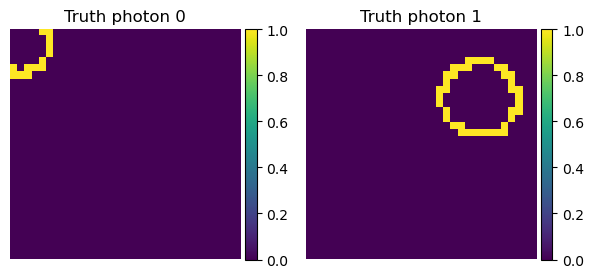

In [141]:
fig, axs = plt.subplots(1,2,figsize=(7,3))

for i,ax in enumerate(axs):

    im = ax.imshow(true[0,i],vmin=0,vmax=1)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    ax.set_title(f'Truth photon {i}')

    ax.axis('off')

plt.show()